<a href="https://colab.research.google.com/github/youtlh/DeepLearningPytorch/blob/main/P1Ch8_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting p1ch7/cifar-10-python.tar.gz to p1ch7/
Files already downloaded and verified


In [3]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

# Convolution

The torch.nn module provides convolutions for 1, 2, and 3 dimensions: nn.Conv1d for time series, nn.Conv2d for images, and nn.Conv3d for volumes or videos.

Input for convolution functions:
1. Number of input features
2. Number of output features
3. Size of the kernel

In [4]:
conv = nn.Conv2d(3, 16, kernel_size=3) # expect B*C*H*W shaped tensor
# 3 for 3 channels RGB, 16 is the output channel.
# The more channels in the output, the more capacity of the network
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [6]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need to add the zeroth batch dimension
img.unsqueeze(0).shape, output.shape
# note that the output image is smaller than the input, lost a few pixels

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

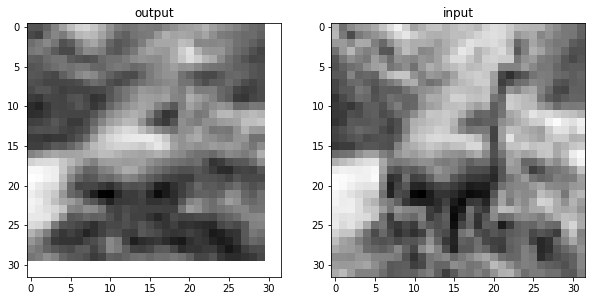

In [7]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1) 
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

## Padding

Defualt PyTorch will slide the convolutional kernel within the input picture, getting width-kernel_width+1 horizontal and vertical positions.

Solution: padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned.

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape
# now the input and output has the same size

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

## Downsampling

Scaling an image by half is the equivalent of taking 4 neighboring pixels as input and producing one pixel as output. There are several ways to do this:
1. Average the 4 pixels -> Average pooling
2. Take the maximum of the 4 pixels -> max pooling, most commonly used approach.
3. Perform a strided convolution, where only every Nth pixel is calculated

In [9]:
pool = nn.MaxPool2d(2)
# maxpooling also offer 1D and 3D version, takes the size of neighborbood as input 
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [10]:
model = nn.Sequential(
  nn.Conv2d(3, 16, kernel_size=3, padding=1), # 1*16*32*32
  nn.Tanh(),
  nn.MaxPool2d(2), #1*16*16*16
  nn.Conv2d(16, 8, kernel_size=3, padding=1), # 1*8*16*16
  nn.Tanh(),
  nn.MaxPool2d(2), #1*8*8*8
  # size mismatch, need to flatten the tensor into 512 1D
  # however, no such reshaping function using nn.Sequential
  nn.Linear(8*8*8, 32),
  nn.Tanh(),
  nn.Linear(32, 2)
)

In [11]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Want to compute something that the premade modules do not cover. Need to make our own nn.Module subclasses that we can use.

# Subclassing nn.Module

In order to subclass nn.Module, at minimum we need to define a forward function that takes the inputs to the module and returns the output.

Typically, our computation will use other modules - premade like convolutions or customized. To include these submodules, we define them in the constructor \_\_init__ and assign them to self for use in the forward function. To accomplish this, need to call super().\_\_init__().

In [12]:
class Net(nn.Module): # Net class is equivalent to the nn.Sequential model
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8*8*8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(x)))
    out = out.view(-1, 8*8*8)
    out = self.fc2(out)
    return out

In [13]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [14]:
# Simplify the non-parametric modules like Tanh and MaxPool2d
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # parameter need tune
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # parameter need tune
    self.fc1 = nn.Linear(8 * 8 * 8, 32) # parameter need tune
    self.fc2 = nn.Linear(32, 2) # parameter need tune
  
  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # no parameter to tune
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # no parameter to tune
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out)) # no parameter to tune
    out = self.fc2(out)
    return out

In [15]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1753, -0.1940]], grad_fn=<AddmmBackward0>)

The core of the convnet is two nested loops: an outer one over the epochs and an inner one of the DataLoader tha tproduces batches from our Dataset.

Within each loop, we have:
1. Feed the inputs through the model (forward pass)
2. Compute the loss (forward pass)
3. Zero any old gradients
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (backward pass)
5. Have the optimizer take a step in toward lower loss

In [16]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs+1):
    loss_train = 0.0
    for imgs, labels in train_loader: # loop over dataset in batches created by dataloader
      outputs = model(imgs) # feeds a batch to the model
      loss = loss_fn(outputs, labels) # compute the loss
      optimizer.zero_grad() # get rid of the gradients from last round
      loss.backward() # perform backward step
      optimizer.step() # update model
      loss_train += loss.item() # sum the loss saw over epoch, use .item() to transform into python number to escape gradients

    if epoch==1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), 
            epoch, loss_train / len(train_loader)))
      # print the average loss per batch

In [17]:
from torch.utils.data import DataLoader
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2022-12-16 07:51:41.491636 Epoch 1, Training loss 0.5357259576487693
2022-12-16 07:52:07.949680 Epoch 10, Training loss 0.33385314996455123
2022-12-16 07:52:37.103391 Epoch 20, Training loss 0.2997303133367733
2022-12-16 07:53:05.537688 Epoch 30, Training loss 0.2745446170781069
2022-12-16 07:53:33.486187 Epoch 40, Training loss 0.25163239093532985
2022-12-16 07:54:01.418058 Epoch 50, Training loss 0.23118834430055255
2022-12-16 07:54:29.201429 Epoch 60, Training loss 0.21283497870158238
2022-12-16 07:54:57.032520 Epoch 70, Training loss 0.19752310638784604
2022-12-16 07:55:33.079294 Epoch 80, Training loss 0.1832170935620548
2022-12-16 07:56:06.701532 Epoch 90, Training loss 0.17064991275406188
2022-12-16 07:56:37.413300 Epoch 100, Training loss 0.15469768296950942


In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # do not want gradients here, turn it off
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # give the index of the highest value
                total += labels.shape[0]  # count the number of examples
                correct += int((predicted == labels).sum())  # count items where prediction = ground truth

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


## Saving Models

In [19]:
# once we are satisfied with the model, save it by:
torch.save(model.state_dict(), 'p1ch7/' + 'birds_vs_airplains.pt')#
# parameters saved (weights and bias)

In [20]:
# When loading, need to deploy the model Net exactly the same
loaded_model = Net()
loaded_model.load_state_dict(torch.load('p1ch7/' + 'birds_vs_airplains.pt'))

<All keys matched successfully>

## Training on GPU

In [22]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [23]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device) # move img and label tensor to gpu
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [24]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device) # move model to GPU
optimizer = optim.SGD(model.parameters(), lr=1e-2) # define optimizer after moving tensor to gpu
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-12-16 07:57:09.441122 Epoch 1, Training loss 0.5857407268445203
2022-12-16 07:57:12.529271 Epoch 10, Training loss 0.34579976187769773
2022-12-16 07:57:15.898547 Epoch 20, Training loss 0.2985771063976227
2022-12-16 07:57:19.266290 Epoch 30, Training loss 0.2752817438286581
2022-12-16 07:57:22.643848 Epoch 40, Training loss 0.257326940727082
2022-12-16 07:57:26.036531 Epoch 50, Training loss 0.24043549957928384
2022-12-16 07:57:29.381551 Epoch 60, Training loss 0.22497884824777106
2022-12-16 07:57:32.784472 Epoch 70, Training loss 0.2117382275640585
2022-12-16 07:57:36.167526 Epoch 80, Training loss 0.19705516303990298
2022-12-16 07:57:39.531877 Epoch 90, Training loss 0.18199130584290074
2022-12-16 07:57:42.967384 Epoch 100, Training loss 0.1664030420220202


In [25]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device) # once again, move to gpu
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())   `0`

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [26]:
# Increase model capacity by widen the model
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32): # pass the width as parameter
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device) # move img and label tensor to gpu
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [28]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-12-16 08:49:50.526016 Epoch 1, Training loss 0.5713192852819042
2022-12-16 08:49:54.535599 Epoch 10, Training loss 0.320792662300122
2022-12-16 08:49:58.404115 Epoch 20, Training loss 0.2792345515102338
2022-12-16 08:50:02.294326 Epoch 30, Training loss 0.24619532030099517
2022-12-16 08:50:06.087287 Epoch 40, Training loss 0.21885584161919394
2022-12-16 08:50:09.901494 Epoch 50, Training loss 0.19377154534219937
2022-12-16 08:50:13.741902 Epoch 60, Training loss 0.16987300569274624
2022-12-16 08:50:17.574287 Epoch 70, Training loss 0.14676034516969305
2022-12-16 08:50:21.918838 Epoch 80, Training loss 0.1249905290782072
2022-12-16 08:50:26.451226 Epoch 90, Training loss 0.10513945314202719
2022-12-16 08:50:30.335482 Epoch 100, Training loss 0.08747062027739112
Accuracy train: 0.96
Accuracy val: 0.90


# Generalization (Weights)

## Regularization (keeping parameters in check)

The first way to stabilize generalization is to add a regularizaiton term to the loss, panelty on larger weight values.

The most popular regularization terms are L2 regularization -> weight decay (sum of squares of all weights in model) and L1 regularization (sum of the absolute values of all weights). Both of them scaled by a small hyperparameter factor. Applying those regularizations to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization.

In [29]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters()) # replacing pow(2.0) with abs() for L1 reg
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [33]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=2e-3) # this is the equivalent with the previous l2_norm calculation
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2022-12-16 09:01:08.172763 Epoch 1, Training loss 0.5534534334756767
2022-12-16 09:01:11.369586 Epoch 10, Training loss 0.33239992371030674
2022-12-16 09:01:14.829859 Epoch 20, Training loss 0.30281585350537754
2022-12-16 09:01:18.276442 Epoch 30, Training loss 0.28062909262575164
2022-12-16 09:01:21.733995 Epoch 40, Training loss 0.26169455753769844
2022-12-16 09:01:25.163260 Epoch 50, Training loss 0.24590320989584466
2022-12-16 09:01:28.608962 Epoch 60, Training loss 0.23172487821548607
2022-12-16 09:01:32.050169 Epoch 70, Training loss 0.2180704745422503
2022-12-16 09:01:35.485348 Epoch 80, Training loss 0.20505350842407555
2022-12-16 09:01:38.933446 Epoch 90, Training loss 0.19253852351266107
2022-12-16 09:01:42.447676 Epoch 100, Training loss 0.1806047054327977
Accuracy train: 0.91
Accuracy val: 0.89


## Dropout (not relying too much on single input)

Zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration. It perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network. In pytorch we do it by adding nn.Dropout module bewteen nonlinear activation function and the nn module of the subsequent layer.

In [35]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4) # need to specify the probability inputs to be zero out
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Dropout is normally active during training, bypassed or equivalently assigned a probability equal to zero during evaluation. This is controled through the train property of the Dropout module. model.train() vs model.eval().

In [36]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
model.eval()
validate(model, train_loader, val_loader)

2022-12-16 09:15:46.875874 Epoch 1, Training loss 0.5771890098501922
2022-12-16 09:15:50.660371 Epoch 10, Training loss 0.3813327168393287
2022-12-16 09:15:54.851256 Epoch 20, Training loss 0.3468913770025703
2022-12-16 09:15:59.090755 Epoch 30, Training loss 0.32333096150000384
2022-12-16 09:16:03.315836 Epoch 40, Training loss 0.3108837195452611
2022-12-16 09:16:07.860658 Epoch 50, Training loss 0.2925879575644329
2022-12-16 09:16:12.074682 Epoch 60, Training loss 0.275858209011661
2022-12-16 09:16:16.249902 Epoch 70, Training loss 0.2622200043717767
2022-12-16 09:16:20.430799 Epoch 80, Training loss 0.25792861468852707
2022-12-16 09:16:24.625111 Epoch 90, Training loss 0.24580063115639292
2022-12-16 09:16:28.867939 Epoch 100, Training loss 0.23372088125936544
Accuracy train: 0.93
Accuracy val: 0.89


## Batch Normalization (keeping activations in check)

Rescale the inputs to the activation funcitons using the mean and standard deviation. In pytorch provided through nn.BatchNorm1D, nn.BatchNorm2d, nn.BatchNorm3d modules.

In [37]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        # batch norm before activation function
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        # batch norm before activation function
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Same with dropout, batch normalization needs to behave differently during training and inference. Need to specify model.eval()

In [38]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
model.eval()
validate(model, train_loader, val_loader)

2022-12-16 09:35:19.431523 Epoch 1, Training loss 0.4469323885288967
2022-12-16 09:35:25.567098 Epoch 10, Training loss 0.2680125804084122
2022-12-16 09:35:31.237824 Epoch 20, Training loss 0.20867995633061526
2022-12-16 09:35:35.849501 Epoch 30, Training loss 0.1594141634169278
2022-12-16 09:35:40.453175 Epoch 40, Training loss 0.11532302250622943
2022-12-16 09:35:45.151241 Epoch 50, Training loss 0.07812251106711329
2022-12-16 09:35:49.795744 Epoch 60, Training loss 0.05137782965662183
2022-12-16 09:35:54.470871 Epoch 70, Training loss 0.03321784527699469
2022-12-16 09:35:59.080815 Epoch 80, Training loss 0.02161294202895681
2022-12-16 09:36:03.729403 Epoch 90, Training loss 0.013607254874696778
2022-12-16 09:36:08.380828 Epoch 100, Training loss 0.009047955808461091
Accuracy train: 0.98
Accuracy val: 0.89


# Generalization (Depth)

Apart from generalizing model by constraining its weight, the second fundamental dimension is depth.

## Skip Connections

Adding depth to a model generally makes training harder to converge. The trick of residual networks which enables us to train network with 100s layer is to use skip connection to short-circuit blocks of layers.

A skip connection is nothing but the addition of the input to the output of a block of layers.

In [39]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [40]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2022-12-16 09:49:23.055400 Epoch 1, Training loss 0.6678417947641604
2022-12-16 09:49:30.072030 Epoch 10, Training loss 0.3540498428283983
2022-12-16 09:49:34.999845 Epoch 20, Training loss 0.30517531627682365
2022-12-16 09:49:42.175153 Epoch 30, Training loss 0.27080814597333314
2022-12-16 09:49:47.544979 Epoch 40, Training loss 0.24038111091039743
2022-12-16 09:49:53.040527 Epoch 50, Training loss 0.21302079138862098
2022-12-16 09:49:58.734006 Epoch 60, Training loss 0.18655457955067326
2022-12-16 09:50:03.985986 Epoch 70, Training loss 0.16028886689407051
2022-12-16 09:50:09.396556 Epoch 80, Training loss 0.13468996157786647
2022-12-16 09:50:13.688669 Epoch 90, Training loss 0.11047044322843765
2022-12-16 09:50:18.051740 Epoch 100, Training loss 0.08895297626116473
Accuracy train: 0.96
Accuracy val: 0.91


In [41]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        # adding the output of the first layer in the forward function to the input of the third
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2022-12-16 09:50:18.923649 Epoch 1, Training loss 0.6431318650579756
2022-12-16 09:50:22.838237 Epoch 10, Training loss 0.32942887514260166
2022-12-16 09:50:27.696496 Epoch 20, Training loss 0.2878354970057299
2022-12-16 09:50:33.192511 Epoch 30, Training loss 0.2521178728076303
2022-12-16 09:50:38.641448 Epoch 40, Training loss 0.22098874039710706
2022-12-16 09:50:44.084614 Epoch 50, Training loss 0.19178733134725293
2022-12-16 09:50:48.711936 Epoch 60, Training loss 0.1638006607817996
2022-12-16 09:50:53.029641 Epoch 70, Training loss 0.1376364352596793
2022-12-16 09:50:57.608547 Epoch 80, Training loss 0.11413391698507747
2022-12-16 09:51:01.916251 Epoch 90, Training loss 0.0881953116530066
2022-12-16 09:51:06.236359 Epoch 100, Training loss 0.06515014627177244
Accuracy train: 0.97
Accuracy val: 0.90


DenseNet apply even more advanced skip connection. It proposed to connect each layer with several other layers downstream through skip connections.

## Building deep network in PyTorch

How to create 100s layer network in PyTorch without losing our minds in the process? The standard stratefy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip connection block, and then build the network dynamically in a for loop.

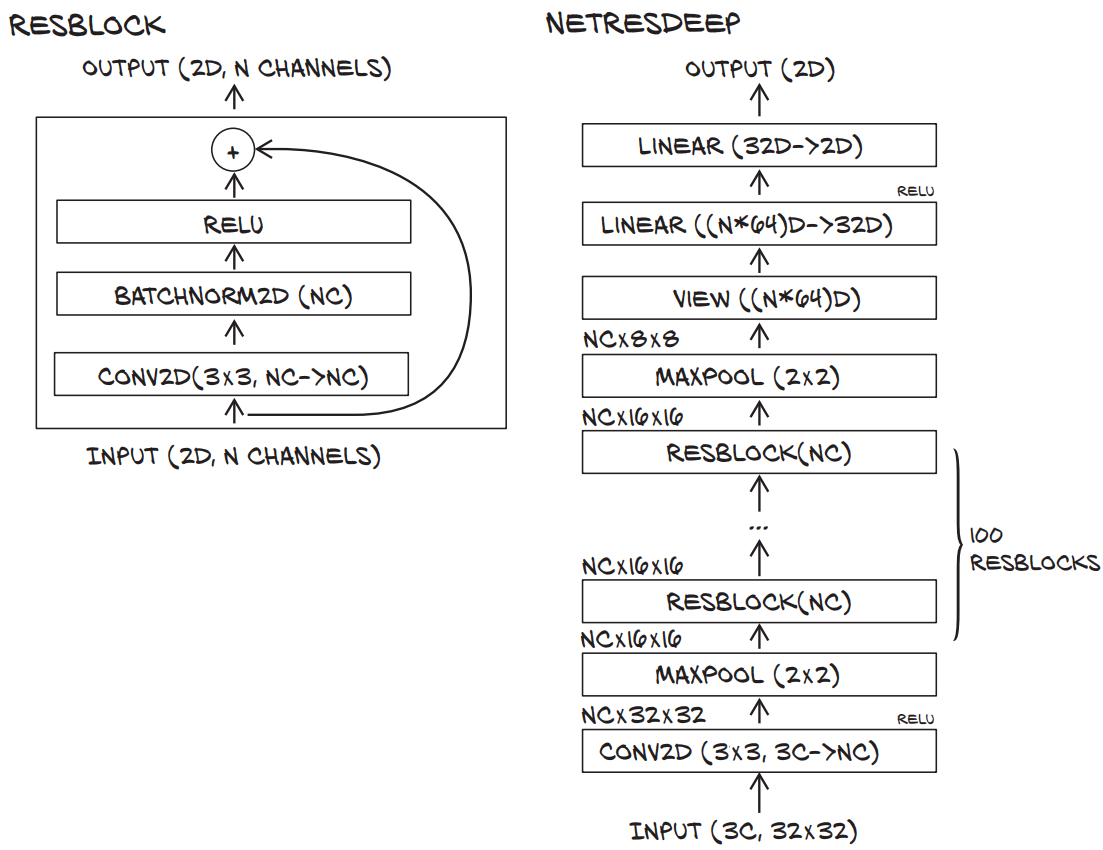

In [44]:
# Create a module subclass whose sole job is to provide the computation for one block
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)
        # batch norm will cancel the effect of bias, so set False
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        # include batch norm in themodel since we are aiming deep
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')
        # use the custom initializations to initialize normal random elements with
        # standard deviation as computed in the ResNet paper. The batch norm is
        # initialized to produce output distributions that initially have 0 mean
        # and 0.5 variance.

        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x # skip connection

In [45]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        # create nn.Sequantial containing list of ResBlock instances. Ensure
        # output of one block used as input to the next
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
# deep model are more fragile, use smaller learning rate
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(model, train_loader, val_loader)

2022-12-16 10:10:37.953807 Epoch 1, Training loss 1.8622934324726177
2022-12-16 10:12:05.572765 Epoch 10, Training loss 0.3073961901816593
2022-12-16 10:13:45.971204 Epoch 20, Training loss 0.22909638005646932
2022-12-16 10:15:20.711888 Epoch 30, Training loss 0.1688122213788473
2022-12-16 10:16:52.795213 Epoch 40, Training loss 0.11355255420207028
2022-12-16 10:18:21.838491 Epoch 50, Training loss 0.07495664893560539
2022-12-16 10:19:50.583771 Epoch 60, Training loss 0.04547640915580426
2022-12-16 10:21:19.970978 Epoch 70, Training loss 0.052604447482272415
2022-12-16 10:22:49.088395 Epoch 80, Training loss 0.031103281276619394
2022-12-16 10:24:17.914356 Epoch 90, Training loss 0.049132444573437295
2022-12-16 10:25:46.874500 Epoch 100, Training loss 0.025297632648915075
Accuracy train: 0.98
Accuracy val: 0.87


## Initialization
Initialization is one of the important tricks in training neural networks. PyTorch has defualt weight initializations that are not ideal. To fix the weight initialization ourselves, the current practice is to looking for what people commonly choose ( smaller variance in weights; zero mean and unit variance outputs from batch norm) as initialization and halved the output variance in the batch norm when the network don't converge

# Compare different models

Summarize the effect of each design modification.

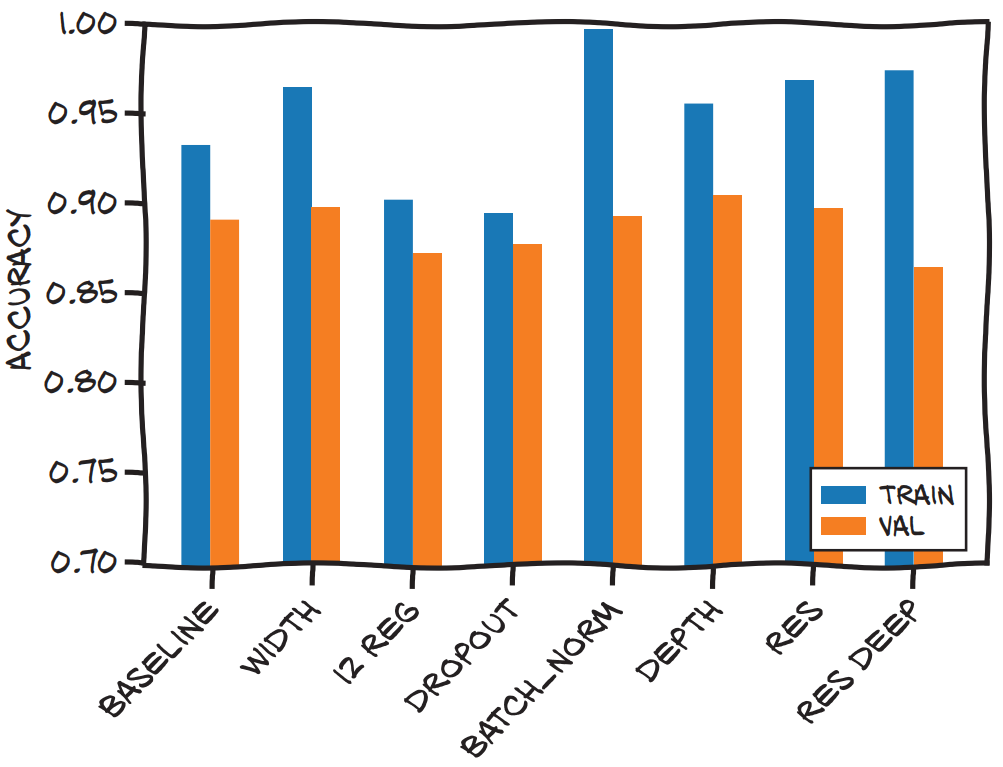